Question 1: Find the centre of the nodes of the swimming route

First we find all the nodes of our swimming route, after that we can define the centre of the nodes (centroid)

[252142901, 331854233, 323929882, 60740166, 178249906, 60740168, 331960285, 178249904, 237852504, 237852501, 117738509, 178261156, 60740852, 5713701424]


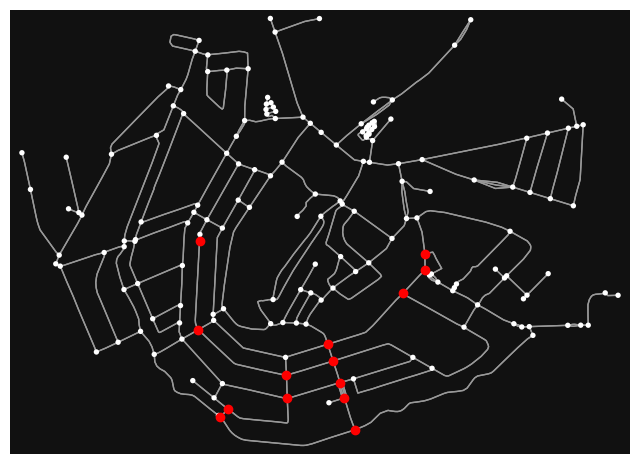

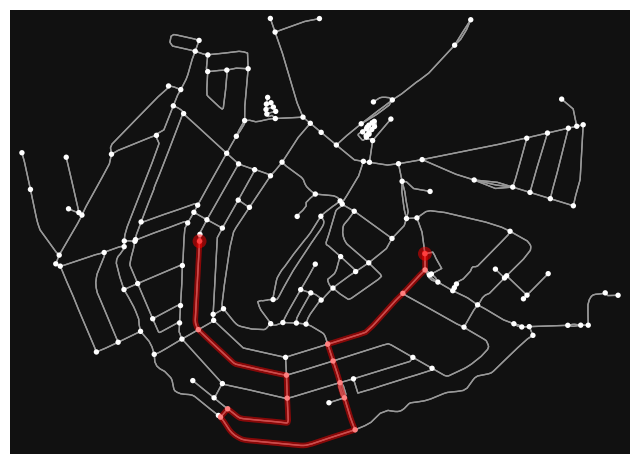

In [196]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Coordinates of our swimming route
coords = [(52.373277, 4.914874), (52.371396, 4.913133), (52.369416, 4.910271),
          (52.365890, 4.901659), (52.364576, 4.902343), (52.362704, 4.902773),
          (52.361792, 4.903786), (52.359224, 4.904724), (52.359252, 4.888917), 
          (52.360749, 4.888679), (52.360716, 4.896166), (52.362973, 4.895984),
          (52.366703, 4.885165), (52.372914, 4.887096)]

# Get the street network for Amsterdam city-centre, only the waterways!
north, south, east, west = 52.3911937, 52.3505111, 4.8618788, 4.9380764
G = ox.graph_from_bbox(north, south, east, west, network_type='all', simplify=True, custom_filter='["waterway"~"river|canal"]')

# Here we plot the network
ox.plot_graph(G, show=False, close=False)

# create an empty list to store the nodes found to use later for the route
all_nodes = []

# looping through the coordinates and plot nodes
for i in range(len(coords)):
    lat, lon = coords[i][0], coords[i][1]
    # Find the node closest to coordinate of the route
    node = ox.distance.nearest_nodes(G, lon, lat)
    all_nodes.append(node)

# Plot the node (in the loop)
    node_data = G.nodes[node]
    x, y = node_data['x'], node_data['y']
    plt.plot(x, y, 'ro', markersize=6)  

print(all_nodes)
#plotting the final route through the nearest nodes
path = all_nodes
pt = ox.graph_to_gdfs(G, edges=False).unary_union.centroid
fig, ax = ox.plot_graph_route(G, path)




Now the route is plotted and all the nodes are set, we can calculate the centre of the nodes (centroid)

In [176]:
#writing a function to generate the centroid by using all the coordinates
def find_centroid(coords):
    total_lat = sum(lat for lat, lon in coords)
    total_lon = sum(lon for lat, lon in coords)
    
    avg_lat = total_lat / len(coords)
    avg_lon = total_lon / len(coords)
    
    return avg_lat, avg_lon


In [177]:
#call the function and print the coordinates of the centroid
centroid = find_centroid(coords)
print(f"Centroid coordinates: {centroid}")

Centroid coordinates: (52.365113, 4.8996835714285725)


''

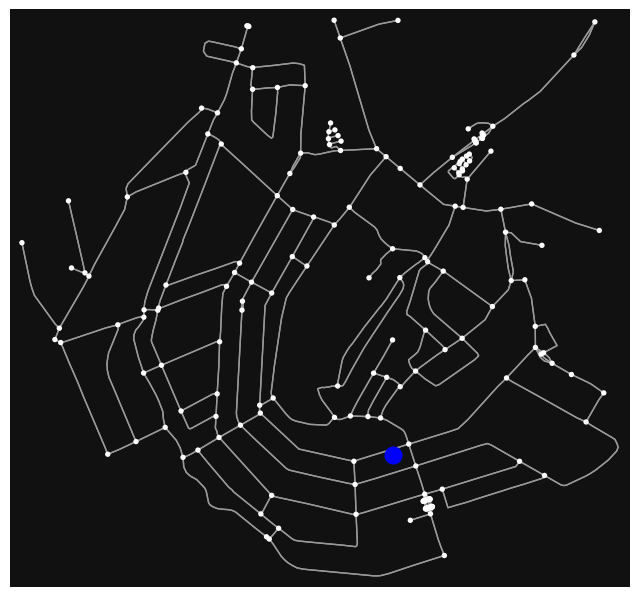

In [178]:
#load the amsterdam waterway map again
place_name = "Amsterdam, Netherlands"
G = ox.graph_from_address(place_name, network_type='all', dist=2000, custom_filter=['waterway'])


ox.plot_graph(G, show=False, close=False)

# Plot the centroid on the map
plt.plot(centroid[1], centroid[0], 'bo', markersize=12)  # Blue dot for centroid

;

Question 2: Use the centre to find a suitable spot for the Event Headquarters

In [191]:
from geopy.geocoders import Nominatim

#address of the exact location
lat = centroid[0]  
lon = centroid[1]  


geolocator = Nominatim(user_agent="geoapiExercises")

#reverse geocoding
location = geolocator.reverse(f"{lat}, {lon}", exactly_one=True)
address = location.address
print('The exact adress for the headquarters :', address)


The exact adress for the headquarters : 586A, Herengracht, Grachtengordel, Centrum, Amsterdam, Noord-Holland, Nederland, 1017 CJ, Nederland


Question 3: Find the closest bus and tram stops at the start and finish of the swimming route. How
many people can be transported within an hour.

Question 4:Can you find which bus and tram lines these are, and can you find their routes?

As the bus and tram stops and therefore the lines had to be identified to answer question 3, question 4 will thus be answered in the process.

In [1]:
import requests
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
from geopy.distance import great_circle

In [2]:
# Set x,y coordinates for the starting point of the swim
x_coor = 52.372870
y_coor = 4.914240
starting_point = (x_coor,y_coor)

# Apply tags to filter for tram stops
tags = {'public_transport':['stop_position']}

# Obtain features (tram stop locations) from the starting point within a distance of 300
features = ox.features.features_from_point(starting_point, tags = tags, dist = 300)

# Pull tram data from online with requests, using data from maps.amsterdam
tram_data = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=TRAMMETRO_PUNTEN_2022&THEMA=trammetro"
pulled_data = requests.get(tram_data)

# Transform pulled data into GeoDataFrame
gdf = gpd.read_file(pulled_data.text)

# Apply great_circle function from OSMNX and distance function within gdf to select only tram stops in radius
gdf['distance'] = gdf['geometry'].apply(lambda stop: great_circle((x_coor, y_coor), (stop.y, stop.x)).meters)
closest_stops = gdf.nsmallest(5, 'distance')

# Print an overview of tram line/stops data
print(closest_stops)

                     Naam Modaliteit Lijn Lijn_select  RADIUS  \
121  Muziekgebouw Bimhuis       Tram   26          26       5   
122    Kattenburgerstraat       Tram   26          26       5   
76                  Artis       Tram   14          14       5   
79        Mr. Visserplein       Tram   14          14       5   
223    Plantage Lepellaan       Tram   14          14       5   

                         Label                  geometry    distance  
121  26 - Muziekgebouw Bimhuis  POINT (4.91302 52.37725)  493.685432  
122    26 - Kattenburgerstraat  POINT (4.92158 52.37612)  615.546946  
76                  14 - Artis  POINT (4.91117 52.36663)  724.698979  
79        14 - Mr. Visserplein  POINT (4.90570 52.36782)  807.082571  
223    14 - Plantage Lepellaan  POINT (4.91548 52.36513)  864.692573  


For the starting point of the swim there are 2 tramlines servicing the nearest stops:

Formatted as: Line, Frequancy, Stops, Destinations

Line 14, 6/hour, 3 stops, Amsterdam Central Station & Flevopark

Line 26, 8/hour, 2 stops, Amsterdam Central Station & IJburg

Data on the bus stops and lines couldn't be retrieved from OSMNX as trying to filter for nodes tagged highway: "bus_stop" or public_transport: "platform", which are the tags OSM uses for bus stops didn't yield any results. So nearby bus stops where identified manually using OSM.

For the buslines there are 2 lines, but 1 is a night bus and is thus excluded:

Line 43, 4/hour, 2 stops, Amsterdam Central Station & Borneo IJland

The frequancy data is taken from the schedule per line from reisinfo.gvb.nl 

Sources: https://reisinfo.gvb.nl/nl/lijnen/14/dienstregeling/heen, https://reisinfo.gvb.nl/nl/lijnen/26/dienstregeling/heen, https://reisinfo.gvb.nl/nl/lijnen/43/dienstregeling/heen

Based on data from over.gvb.nl on the sizes of the busses each bus has space for 150 passengers (45 seated, 105 standing), while the tram size varies with the smallest and largest being 128 (52 seated, 76 standing) and 145 (50 seated, 125 standing) respectively.

Sources: https://over.gvb.nl/ov-in-amsterdam/voer-en-vaartuigen/tram-in-cijfers/, https://over.gvb.nl/ov-in-amsterdam/voer-en-vaartuigen/bus-in-cijfers/

In [3]:
# Calculate the number of passengers per bus then per hour
passengers_seated = 45
passengers_standing = 105

total_passengers = passengers_seated + passengers_standing

bus_passengers_per_hour = total_passengers * 4
print("Bus passengers per hour:", + bus_passengers_per_hour)

# Calculate the number of passengers per full tram then per hour
# Number of total potential passengers varies per type of tram so we calculate a minimum and maximum,
# based on the trams with the smallest and largest number of passengers possible

# First input the tram minimum passenger data for when the tram would be full
passangers_tram_seated_min = 52
passangers_tram_standing_min = 76

# Then input the tram maximum passenger data for when the tram would be full
passangers_tram_seated_max = 50 #might seem wierd but the tram with the highest total passengers only has 50 seats with 25 to 30 more standing spots
passangers_tram_standing_max = 125

# Now we calculate the minimum and maximum number of people per full tram
passengers_tram_min = passangers_tram_seated_min + passangers_tram_standing_min
passengers_tram_max = passangers_tram_seated_max + passangers_tram_standing_max

# Make a dictionary to map tram names with the frequancy data
tram_data = {"Tram_14": 6 , "Tram_26": 8}

# Define a new function consisting of a while loop to calculate the number of passengers per hour per line
def min_passengers_per_hour(tram_data, min_passengers):
    results = []  # Initialize an empty list to store results
    for tram_name, i in tram_data.items():
        tram_passengers_per_hour_min = i * min_passengers
        print(f"{tram_name}: Minimum passengers per hour per direction = {tram_passengers_per_hour_min}")
        results.append(tram_passengers_per_hour_min)  # Append each result to the list
    return results

# Call the function and pass the dictionary of tram names and frequencies
min_results = min_passengers_per_hour(tram_data, passengers_tram_min)

# Calculate the sum of the minimum passenger results
total_min_passengers = sum(min_results)
print(f"Total minimum passengers per hour for tram: {total_min_passengers}")

# Calculate the total for the situation with the largest trams, multiply by two to account for the two directions the trams and busses go in
print((2*(total_min_passengers + bus_passengers_per_hour)), "people can be transported per hour at minimum")

# Now define a similar function for the maximum number of passangers per hour per line
def max_passengers_per_hour(tram_data, max_passengers):
    results = []  # Initialize an empty list to store results
    for tram_name, i in tram_data.items():
        tram_passengers_per_hour_max = i * max_passengers
        print(f"{tram_name}: Minimum passengers per hour per direction = {tram_passengers_per_hour_max}")
        results.append(tram_passengers_per_hour_max)  # Append each result to the list
    return results

# Call the function and pass the dictionary of tram names and frequencies
max_results = max_passengers_per_hour(tram_data, passengers_tram_max)

# Calculate the sum of the minimum passenger results
total_max_passengers = sum(max_results)
print(f"Total maximum passengers per hour for tram: {total_max_passengers}")

# Calculate the total for the situation with the largest trams, multiply by two to account for the two directions the trams and busses go in
print((2*(total_max_passengers + bus_passengers_per_hour)), "people can be transported per hour at maximum")

Bus passengers per hour: 600
Tram_14: Minimum passengers per hour per direction = 768
Tram_26: Minimum passengers per hour per direction = 1024
Total minimum passengers per hour for tram: 1792
4784 people can be transported per hour at minimum
Tram_14: Minimum passengers per hour per direction = 1050
Tram_26: Minimum passengers per hour per direction = 1400
Total maximum passengers per hour for tram: 2450
6100 people can be transported per hour at maximum


By combining the data on the maximum number of passengers for a full bus and full trams (keeping in mind the the range of maximum passengers for the smallest and largest tram sizes) we get the results as shown above.

To summarize:
Between 4784 and 6100 people can be transported per hour depending on the variable size of the trams.

In [4]:
# Import folium and CircleMarker to show the found tram stops on a map
import folium
from folium import CircleMarker

In [5]:
# Create a Folium map centered at the starting point
m = folium.Map(location = [x_coor, y_coor], zoom_start = 15)

# Add a marker for the starting location to the map
folium.Marker(location=[x_coor, y_coor], popup="Starting Point").add_to(m)

# Add markers for the closest stops
for index, row in closest_stops.iterrows():
    coords = [row['geometry'].y, row['geometry'].x]
    
    # Create a custom icon to match the CircleMarker appearance
    custom_icon = folium.DivIcon(
        html=f'<div style="background-color: red; border-radius: 50%; width: 20px; height: 20px;"></div>',
        icon_size=(10, 10))
    folium.Marker(location=coords, icon=custom_icon).add_to(m)

# Make a list of the locations and their attributes (latitude, longitude), 
# as we didn't manage to get a working code to search for nearest bus stops with OSMNX the stops were added mannualy through their coordinates
locations1 = [
    (52.3727832, 4.9183660),
    (52.3710067, 4.9133407),
    (52.3707704, 4.9160979)]

# Add markers for additional locations
for location in locations1:
    lat, lon = location
    
    # Create a custom icon for additional locations
    custom_icon = folium.DivIcon(
        html=f'<div style = "background-color: blue; border-radius: 50%; width: 20px; height: 20px;"></div>',
        icon_size = (10, 10))
    folium.Marker(location = [lat, lon], icon = custom_icon).add_to(m)

# Print the map with the locations
m

In the above map the starting point of the swim is shown as the blue/white marker. With the nearest bus and tram stops shown in blue en red respectively.

Now for the answers to questions 3 & 4 for the end point/finish of the swim

In [6]:
# Set x,y coordinates for the end point/finish of the swim
x_coor2 = 52.374219
y_coor2 = 4.885003
end_point = (x_coor2,y_coor2)

# Apply tags to filter for tram stops
tags = {'public_transport': ['stop_position']}

# Obtain features (tram stop locations) from the starting point within a distance of 300
features2 = ox.features.features_from_point(end_point, tags = tags, dist = 300)

# Pull tram data from online with requests, using data from maps.amsterdam
url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=TRAMMETRO_PUNTEN_2022&THEMA=trammetro"
response = requests.get(url)

# Transform pulled data into GeoDataFrame
gdf = gpd.read_file(response.text)

# Apply great_circle function from OSMNX and distance function within gdf to select only tram stops in radius
gdf['distance'] = gdf['geometry'].apply(lambda stop: great_circle((x_coor2, y_coor2), (stop.y, stop.x)).meters)
closest_stops = gdf.nsmallest(5, 'distance')

# Print an overview of tram line/stops data
print(closest_stops)

                   Naam Modaliteit              Lijn  Lijn_select  RADIUS  \
205         Westermarkt       Tram           13 | 17        13|17       5   
64   Dam / Paleisstraat       Tram  2 | 12 | 13 | 17  02|12|13|17       5   
130         Marnixplein       Tram                 5            5       5   
215         Bloemgracht       Tram                 5            5       5   
0      Nieuwezijds Kolk       Tram  2 | 12 | 13 | 17  02|12|13|17       5   

                                     Label                  geometry  \
205                  13 | 17 - Westermarkt  POINT (4.88411 52.37403)   
64   2 | 12 | 13 | 17 - Dam / Paleisstraat  POINT (4.89051 52.37316)   
130                        5 - Marnixplein  POINT (4.87847 52.37748)   
215                        5 - Bloemgracht  POINT (4.87645 52.37434)   
0      2 | 12 | 13 | 17 - Nieuwezijds Kolk  POINT (4.89334 52.37607)   

       distance  
205   64.238127  
64   392.049140  
130  572.893757  
215  580.732338  
0    602.50145

So there are 5 tramlines that service the nearest tramstops.

Formatted as: Line, Frequancy, Stops, Destinations

Line 2, 8/hour, 2 stops, 

Line 5, 5/hour, 2 stops, 

Line 12, 7/hour, 2 stops, 

Line 13, 8/hour, 3 stops, 

Line 17, 9/hour, 3 stops, 
              
The frequancy data is taken from the schedule per line from reisinfo.gvb.nl

Sources: https://reisinfo.gvb.nl/nl/lijnen/2/dienstregeling/heen, https://reisinfo.gvb.nl/nl/lijnen/5/dienstregeling/heen, https://reisinfo.gvb.nl/nl/lijnen/12/dienstregeling/, https://reisinfo.gvb.nl/nl/lijnen/13/dienstregeling/heenheen, https://reisinfo.gvb.nl/nl/lijnen/17/dienstregeling/heen

Here we didn't include the buslines as the nearby bus stops are only serviced by the night busses, thus they don't contribute to the ability of participants/viewers to reach the location of the finishline.

In [7]:
# Calculating the number of passengers per full tram then per hour
# Number of total potential passengers varies per type of tram so we calculate a minimum and maximum,
# based on the trams with the smallest and largest number of passengers possible
#Here we are using the tram, min, max -passenger data for when a tram is full from before

# Make a dictionary to map tram names with the frequancy data
tram_data_finish = {"Tram_2": 8 , "Tram_5": 5, "Tram_12": 7, "Tram_13": 8, "Tram_17": 9}

# Define a new function consisting of a while loop to calculate the number of passengers per hour per line
def min_passengers_per_hour(tram_data, min_passengers):
    results = []  # Initialize an empty list to store results
    for tram_name, i in tram_data.items():
        tram_passengers_per_hour_min = i * min_passengers
        print(f"{tram_name}: Minimum passengers per hour per direction = {tram_passengers_per_hour_min}")
        results.append(tram_passengers_per_hour_min)  # Append each result to the list
    return results

# Call the function and pass the dictionary of tram names and frequencies
min_results_finish = min_passengers_per_hour(tram_data_finish, passengers_tram_min)

# Calculate the sum of the minimum passenger results
total_min_passengers_finish = sum(min_results_finish)
print(f"Total minimum passengers per hour for tram: {total_min_passengers_finish}")

# Calculate the total for the situation with the largest trams, multiply by two to account for the two directions the trams and busses go in
print((2*total_min_passengers), "people can be transported per hour at minimum")

# Now define a similar function for the maximum number of passangers per hour per line
def max_passengers_per_hour(tram_data, max_passengers):
    results = []  # Initialize an empty list to store results
    for tram_name, i in tram_data.items():
        tram_passengers_per_hour_max = i * max_passengers
        print(f"{tram_name}: Maximum passengers per hour per direction = {tram_passengers_per_hour_max}")
        results.append(tram_passengers_per_hour_max)  # Append each result to the list
    return results

# Call the function and pass the dictionary of tram names and frequencies
max_results_finish = max_passengers_per_hour(tram_data_finish, passengers_tram_max)

# Calculate the sum of the minimum passenger results
total_max_passengers_finish = sum(max_results_finish)
print(f"Total maximum passengers per hour for tram: {total_max_passengers_finish}")

# Calculate the total for the situation with the largest trams, multiply by two to account for the two directions the trams and busses go in
print((2*total_max_passengers_finish), "people can be transported per hour at maximum")

Tram_2: Minimum passengers per hour per direction = 1024
Tram_5: Minimum passengers per hour per direction = 640
Tram_12: Minimum passengers per hour per direction = 896
Tram_13: Minimum passengers per hour per direction = 1024
Tram_17: Minimum passengers per hour per direction = 1152
Total minimum passengers per hour for tram: 4736
3584 people can be transported per hour at minimum
Tram_2: Maximum passengers per hour per direction = 1400
Tram_5: Maximum passengers per hour per direction = 875
Tram_12: Maximum passengers per hour per direction = 1225
Tram_13: Maximum passengers per hour per direction = 1400
Tram_17: Maximum passengers per hour per direction = 1575
Total maximum passengers per hour for tram: 6475
12950 people can be transported per hour at maximum


Once more by combining the data on the maximum number of passengers for a full bus and full trams (keeping in mind the the range of maximum passengers for the smallest and largest tram sizes) we get the results as shown above.

To summarize:
Between 9472 and 12950 people can be transported per hour depending on the variable size of the trams.

In [8]:
# Create a Folium map centered at your starting point
m2 = folium.Map(location = [x_coor2, y_coor2], zoom_start = 15)

# Add marker for the end point/finish of the swimming route
folium.Marker(location=[x_coor2, y_coor2], popup="End Point").add_to(m2)

# Add markers for the closest stops
for index, row in closest_stops.iterrows():
    coords = [row['geometry'].y, row['geometry'].x]
    
    # Create a custom icon to match the CircleMarker appearance
    custom_icon = folium.DivIcon(
        html=f'<div style="background-color: red; border-radius: 50%; width: 20px; height: 20px;"></div>',
        icon_size=(10, 10))
    folium.Marker(location=coords, icon=custom_icon).add_to(m2)

# Print the map with the locations
m2

As there are no relevant buslines servicing the nearby bus stops, only the nearest tram stops have been shown in the above map.

Question 5: Calculate the centrality of the start, finish, and centre node of the route. Which
centrality calculation makes the most sense

We use centrality because then it is visible how closeby certain points are. We make use of the waterway map to calculate this, the organization will mostly will be in the headquarters and in this way they know how far points on the route are.

In [183]:
#beginpoint coordinates
begpoint_x = 4.914874 
begpoint_y = 52.373277
#endpoint coordinates
endpoint_x = 4.887096 
endpoint_y = 52.372914
#the center coordinates are calculated above with average x and y
center_x = centroid[1]
center_y = centroid[0]

place_name = "Nieuwmarkt 112, Amsterdam, Netherlands"
map = ox.graph_from_address(place_name, network_type='all', dist=2000, custom_filter=['waterway'])

#find nearest nodes
nearest_node = ox.distance.nearest_nodes(map, begpoint_x, begpoint_y, return_dist=True)
print(nearest_node)
nearest_node2 = ox.distance.nearest_nodes(map, endpoint_x, endpoint_y, return_dist=True)
print(nearest_node2)
nearest_center_node = ox.distance.nearest_nodes(map, center_x, center_y, return_dist=True)
print(nearest_center_node)

centrality_beg = nx.closeness_centrality(map, 252142901)
centrality_center = nx.closeness_centrality(map, 60740166)
centrality_end = nx.closeness_centrality(map,5713701424)
print()
print("The centrality of the beginning is", centrality_beg)
print('the centrality of the headquarter is', centrality_center)
print("The centrality of the finish is", centrality_end)


(252142901, 109.12753037207415)
(5713701424, 168.60491308553287)
(60740166, 127.32349373231014)

The centrality of the beginning is 0.12170860152135751
the centrality of the headquarter is 0.14689265536723164
The centrality of the finish is 0.12659768715763847


Question 6: Find all cafes, restaurants near the finish line. Walking time smaller than 10 minutes.

 Based on the average walking speed of a pedestrian being 1,42 meters per second, we can then calculate how far they may walk within then minutes.

In [9]:
print("Average walking distance in 10 mintes is", int(1.42*60*10), "meters")

Average walking distance in 10 mintes is 851 meters


Keeping in mind how crouded it could become with a large number of spectators/visitors we thus limited the walking distance to 800 meters.

Shown below using OSMNX and folium the locations of cafes and restaurants within 800 meters wil be plotted in a map.

In [10]:
import folium
import osmnx as ox

# Define the center point
latitude = 52.374219
longitude = 4.885003
end_point = 52.374219, 4.885003

# Create a Folium map centered at the specified point
m3 = folium.Map(location=[latitude, longitude], zoom_start = 15)

# Fetch restaurant and cafe locations within 800 meters of the "End_Point"
tags = {'amenity': ['restaurant', 'cafe']}
radius = 800  # Specify the radius in meters
restaurants_and_cafes = ox.features_from_point(end_point, tags=tags, dist=radius)

# Filter the restaurants_and_cafes DataFrame to remove the "Kosmos" marker
filtered_restaurants_and_cafes = restaurants_and_cafes[restaurants_and_cafes['name'] != 'Kosmos'] 
# Manuall checking showed that marker Kosmos was outside of the specified radius

# Define the center point
latitude = 52.374219
longitude = 4.885003

# Create a Folium map centered at the specified point
m3 = folium.Map(location=[latitude, longitude], zoom_start=14, tiles="CartoDB Positron")

def add_restaurant_cafe_markers(row):
    if 'geometry' in row and hasattr(row['geometry'], 'y') and hasattr(row['geometry'], 'x'):
        lat, lon = row['geometry'].y, row['geometry'].x
        name = row.get('name', 'Unknown')
        folium.CircleMarker(location=[lat, lon], radius=3, fill=True, color='blue', fill_color='blue', fill_opacity=0.6, popup=name).add_to(m3)

# Apply the function to add markers for each restaurant/cafe location
filtered_restaurants_and_cafes.apply(add_restaurant_cafe_markers, axis=1)

# Show the map
m3

The above map shows the locations of cafes and restaurants within a 10 minute walking distance.